In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical

from doa import convert_signals_to_covariance_input
from baselines import evaluate_cnn_across_epsilons, train_phase1_model_doa, train_phase2_model_doa, create_inference_model_doa

In [2]:
data = np.load('../data/processed/improved_doa_signals.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [3]:
# Convert signals to covariance input
X_train_cov = convert_signals_to_covariance_input(X_train, turn_on_time=750, block_size=750)
X_test_cov = convert_signals_to_covariance_input(X_test, turn_on_time=750, block_size=750)

# Convert labels to one-hot (DoA classification)
y_train_onehot = to_categorical(y_train, num_classes=61)
y_test_onehot = to_categorical(y_test, num_classes=61)

## Define Epsilon Values

In [4]:
epsilon_values_inf = np.linspace(0.0, 0.015, 20)
epsilon_values_l2 = np.linspace(0.0, 0.08, 20)

In [5]:
epsilon_linf = epsilon_values_inf[3]
print(f"Selected epsilon values: Linf = {epsilon_linf}")

Selected epsilon values: Linf = 0.0023684210526315787


In [6]:
epsilon_l2 = epsilon_values_l2[3]
print(f"Selected epsilon values: L2 = {epsilon_l2}")

Selected epsilon values: L2 = 0.01263157894736842


## Defense Distillation

In [7]:
T = 5.0

# Phase 1 — Train model with softmax(T) on hard labels
phase1_model = train_phase1_model_doa(X_train_cov, y_train_onehot, T=T, save_path="../models/attack/doa_teacher_phase1.keras")

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1938 - loss: 3.5220 - val_accuracy: 0.0171 - val_loss: 4.0527 - learning_rate: 1.0000e-04
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5634 - loss: 1.5354 - val_accuracy: 0.0717 - val_loss: 3.7484 - learning_rate: 1.0000e-04
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6726 - loss: 0.9333 - val_accuracy: 0.7517 - val_loss: 2.5413 - learning_rate: 1.0000e-04
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7272 - loss: 0.7027 - val_accuracy: 0.8375 - val_loss: 0.9664 - learning_rate: 1.0000e-04
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7835 - loss: 0.5673 - val_accuracy: 0.8725 - val_loss: 0.5145 - learning_rate: 1.0000e-04
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8174 - loss: 0.4770 - val_accuracy: 0.9029 - val_loss: 0.4022 - learning_rate: 1.0000e-04
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc

In [8]:
# Generate soft labels
soft_labels = phase1_model.predict(X_train_cov)

750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [9]:
# Phase 2 — Retrain with softmax(T) on soft labels
phase2_model = train_phase2_model_doa(X_train_cov, soft_labels, T=T, save_path="../models/attack/doa_student_phase2.keras")

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1867 - loss: 3.3753 - val_accuracy: 0.0758 - val_loss: 3.9205 - learning_rate: 1.0000e-04
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5759 - loss: 1.3530 - val_accuracy: 0.3871 - val_loss: 3.5874 - learning_rate: 1.0000e-04
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6873 - loss: 0.7840 - val_accuracy: 0.7417 - val_loss: 2.3400 - learning_rate: 1.0000e-04
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7523 - loss: 0.5652 - val_accuracy: 0.8379 - val_loss: 0.7744 - learning_rate: 1.0000e-04
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7951 - loss: 0.4409 - val_accuracy: 0.8833 - val_loss: 0.3719 - learning_rate: 1.0000e-04
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8369 - loss: 0.3555 - val_accuracy: 0.8896 - val_loss: 0.2734 - learning_rate: 1.0000e-04
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc

In [10]:
# Inference model with softmax(T=1)
model_distill = create_inference_model_doa("../models/attack/doa_student_phase2.keras")

In [11]:
# Evaluate on clean test set
test_loss, test_acc = model_distill.evaluate(X_test_cov, y_test_onehot)
print(f"Clean test accuracy (defensive distillation): {test_acc:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9666 - loss: 0.0758
Clean test accuracy (defensive distillation): 0.9668


## Evaluate and Compare Results

In [12]:
fgsm_inf = pd.read_csv('../results/improved_attacks/doa/fgsm_inf_accuracy.csv')
pgd_inf = pd.read_csv('../results/improved_attacks/doa/pgd_inf_accuracy.csv')
fgsm_l2 = pd.read_csv('../results/improved_attacks/doa/fgsm_l2_accuracy.csv')
pgd_l2 = pd.read_csv('../results/improved_attacks/doa/pgd_l2_accuracy.csv')

In [13]:
# distillation
acc_distill_fgsm_inf, preds_distill_fgsm_inf = evaluate_cnn_across_epsilons(
    model_distill, X_test_cov, y_test_onehot,
    epsilon_values_inf, attack_type='fgsm', norm='inf'
)

[FGSM-inf] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[FGSM-inf] Epsilon = 0.00079
Mean absolute perturbation at epsilon=0.00079: 0.000740
[FGSM-inf] Epsilon = 0.00158
Mean absolute perturbation at epsilon=0.00158: 0.001480
[FGSM-inf] Epsilon = 0.00237
Mean absolute perturbation at epsilon=0.00237: 0.002220
[FGSM-inf] Epsilon = 0.00316
Mean absolute perturbation at epsilon=0.00316: 0.002961
[FGSM-inf] Epsilon = 0.00395
Mean absolute perturbation at epsilon=0.00395: 0.003701
[FGSM-inf] Epsilon = 0.00474
Mean absolute perturbation at epsilon=0.00474: 0.004441
[FGSM-inf] Epsilon = 0.00553
Mean absolute perturbation at epsilon=0.00553: 0.005181
[FGSM-inf] Epsilon = 0.00632
Mean absolute perturbation at epsilon=0.00632: 0.005921
[FGSM-inf] Epsilon = 0.00711
Mean absolute perturbation at epsilon=0.00711: 0.006661
[FGSM-inf] Epsilon = 0.00789
Mean absolute perturbation at epsilon=0.00789: 0.007401
[FGSM-inf] Epsilon = 0.00868
Mean absolute perturbation at epsilo

In [14]:
fgsm_inf['distill_trained'] = acc_distill_fgsm_inf

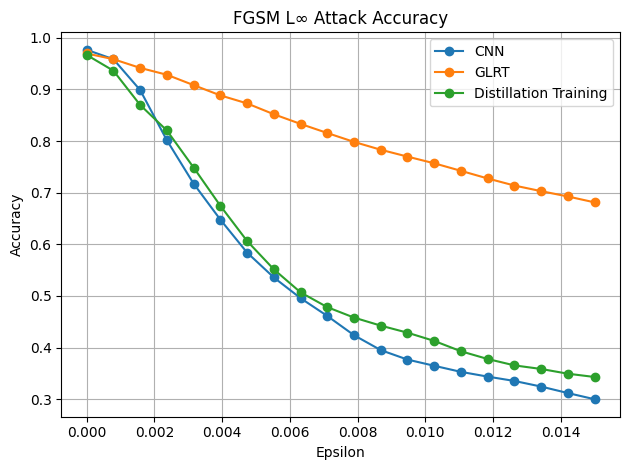

In [15]:
fgsm_inf.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "distill_trained"],
    marker='o'
)

plt.title("FGSM L∞ Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "Distillation Training"])
plt.tight_layout()
plt.show()

In [16]:
fgsm_inf.to_csv('../results/baseline/doa/fgsm_inf_accuracy_with_distill.csv', index=False)

In [17]:
# distillation
acc_distill_fgsm_l2, preds_distill_fgsm_l2 = evaluate_cnn_across_epsilons(
    model_distill, X_test_cov, y_test_onehot,
    epsilon_values_l2, attack_type='fgsm', norm='2'
)

[FGSM-2] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[FGSM-2] Epsilon = 0.00421
Mean absolute perturbation at epsilon=0.00421: 0.000032
[FGSM-2] Epsilon = 0.00842
Mean absolute perturbation at epsilon=0.00842: 0.000064
[FGSM-2] Epsilon = 0.01263
Mean absolute perturbation at epsilon=0.01263: 0.000096
[FGSM-2] Epsilon = 0.01684
Mean absolute perturbation at epsilon=0.01684: 0.000128
[FGSM-2] Epsilon = 0.02105
Mean absolute perturbation at epsilon=0.02105: 0.000160
[FGSM-2] Epsilon = 0.02526
Mean absolute perturbation at epsilon=0.02526: 0.000192
[FGSM-2] Epsilon = 0.02947
Mean absolute perturbation at epsilon=0.02947: 0.000223
[FGSM-2] Epsilon = 0.03368
Mean absolute perturbation at epsilon=0.03368: 0.000255
[FGSM-2] Epsilon = 0.03789
Mean absolute perturbation at epsilon=0.03789: 0.000287
[FGSM-2] Epsilon = 0.04211
Mean absolute perturbation at epsilon=0.04211: 0.000319
[FGSM-2] Epsilon = 0.04632
Mean absolute perturbation at epsilon=0.04632: 0.000351
[FGS

In [18]:
fgsm_l2['distill_trained'] = acc_distill_fgsm_l2

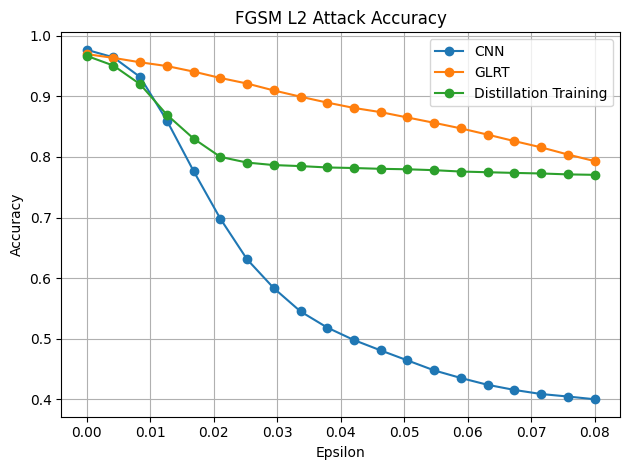

In [19]:
fgsm_l2.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "distill_trained"],
    marker='o'
)

plt.title("FGSM L2 Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "Distillation Training"])
plt.tight_layout()
plt.show()

In [20]:
fgsm_l2.to_csv('../results/baseline/doa/fgsm_l2_accuracy_with_distill.csv', index=False)

In [21]:
# distillation
acc_distill_pgd_inf, preds_distill_pgd_inf = evaluate_cnn_across_epsilons(
    model_distill, X_test_cov, y_test_onehot,
    epsilon_values_inf, attack_type='pgd', norm='inf'
)

[PGD-inf] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[PGD-inf] Epsilon = 0.00079
Mean absolute perturbation at epsilon=0.00079: 0.000696
[PGD-inf] Epsilon = 0.00158
Mean absolute perturbation at epsilon=0.00158: 0.001336
[PGD-inf] Epsilon = 0.00237
Mean absolute perturbation at epsilon=0.00237: 0.001935
[PGD-inf] Epsilon = 0.00316
Mean absolute perturbation at epsilon=0.00316: 0.002502
[PGD-inf] Epsilon = 0.00395
Mean absolute perturbation at epsilon=0.00395: 0.003040
[PGD-inf] Epsilon = 0.00474
Mean absolute perturbation at epsilon=0.00474: 0.003554
[PGD-inf] Epsilon = 0.00553
Mean absolute perturbation at epsilon=0.00553: 0.004039
[PGD-inf] Epsilon = 0.00632
Mean absolute perturbation at epsilon=0.00632: 0.004495
[PGD-inf] Epsilon = 0.00711
Mean absolute perturbation at epsilon=0.00711: 0.004915
[PGD-inf] Epsilon = 0.00789
Mean absolute perturbation at epsilon=0.00789: 0.005310
[PGD-inf] Epsilon = 0.00868
Mean absolute perturbation at epsilon=0.00868: 0

In [22]:
pgd_inf['distill_trained'] = acc_distill_pgd_inf

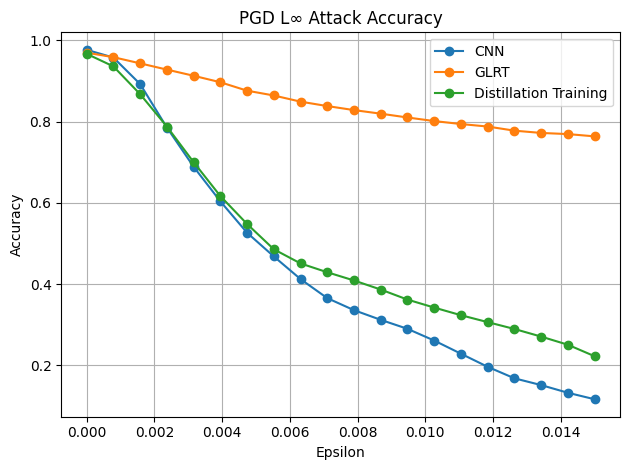

In [23]:
pgd_inf.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "distill_trained"],
    marker='o'
)

plt.title("PGD L∞ Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "Distillation Training"])
plt.tight_layout()
plt.show()

In [24]:
pgd_inf.to_csv('../results/baseline/doa/pgd_inf_accuracy_with_distill.csv', index=False)

In [25]:
# distillation
acc_distill_pgd_l2, preds_distill_pgd_l2 = evaluate_cnn_across_epsilons(
    model_distill, X_test_cov, y_test_onehot,
    epsilon_values_l2, attack_type='pgd', norm='2'
)

[PGD-2] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[PGD-2] Epsilon = 0.00421
Mean absolute perturbation at epsilon=0.00421: 0.000033
[PGD-2] Epsilon = 0.00842
Mean absolute perturbation at epsilon=0.00842: 0.000066
[PGD-2] Epsilon = 0.01263
Mean absolute perturbation at epsilon=0.01263: 0.000100
[PGD-2] Epsilon = 0.01684
Mean absolute perturbation at epsilon=0.01684: 0.000134
[PGD-2] Epsilon = 0.02105
Mean absolute perturbation at epsilon=0.02105: 0.000168
[PGD-2] Epsilon = 0.02526
Mean absolute perturbation at epsilon=0.02526: 0.000202
[PGD-2] Epsilon = 0.02947
Mean absolute perturbation at epsilon=0.02947: 0.000233
[PGD-2] Epsilon = 0.03368
Mean absolute perturbation at epsilon=0.03368: 0.000260
[PGD-2] Epsilon = 0.03789
Mean absolute perturbation at epsilon=0.03789: 0.000283
[PGD-2] Epsilon = 0.04211
Mean absolute perturbation at epsilon=0.04211: 0.000302
[PGD-2] Epsilon = 0.04632
Mean absolute perturbation at epsilon=0.04632: 0.000320
[PGD-2] Epsilon 

In [26]:
pgd_l2['distill_trained'] = acc_distill_pgd_l2

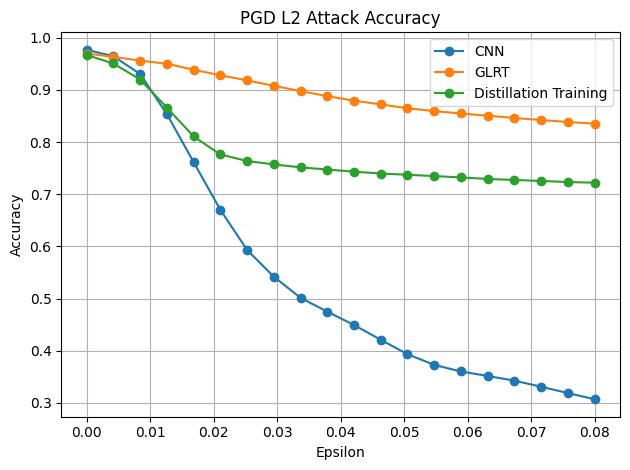

In [27]:
pgd_l2.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "distill_trained"],
    marker='o'
)

plt.title("PGD L2 Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "Distillation Training"])
plt.tight_layout()
plt.show()

In [28]:
pgd_l2.to_csv('../results/baseline/doa/pgd_l2_accuracy_with_distill.csv', index=False)